# Agent-Based Simulation: Convergence 

In [24]:
import matplotlib.pyplot as plt
from pathlib import Path
import random 
import pandas as pd
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from scipy import optimize as opt
from scipy import integrate as intg
from scipy.optimize import least_squares
from scipy.stats import beta
from scipy.stats import bernoulli
from scipy.stats import cumfreq, beta
from utils import simulate_game

%matplotlib inline
plt.style.use('../notebook.mplstyle')

SEED = 1 

## Exogenous Parameters


In [25]:
# Setting exogenous parameters
def reset_exog_params():
    global Bm, Bw, bm_vals, bw_vals, δ, um, uw, Fm, Fw, λm, λw
    Bm = 10
    Bw = 10
    bm_vals = range(1,Bm+1) 
    bw_vals = range(1,Bw+1)
    
    δ = 0.97
    um = lambda θ : θ 
    uw = lambda θ : θ
    Fm = beta(3,3)
    Fw = beta(3,3)
    λm = 50
    λw = 50

def exog_params():
    return (Bm, Bw, bm_vals, bw_vals, δ, um, uw, Fm, Fw, λm, λw)

## Steady State with Cutoff Strategies

In [26]:
def steady_state_men(μ): 
    # Computing z's
    zm = []
    for b in bm_vals:
        if b==Bm:
            zm.append(1-δ*Fw.cdf(μ[Bm-1]))
        else:    
            z=1
            for i in range(1, Bm-b+1): 
                z *= ((δ*(1-Fw.cdf(μ[Bm-i])))/(1-δ*Fw.cdf(μ[Bm-i-1])))   
            zm.append(z)  
    # Computing steady-state mass 
    Nm = (λm) * ((zm[Bm-1] - δ * zm[0] * (1 - Fw.cdf(μ[0]))) / ((1-δ) * zm[Bm-1]))

    # Computing steady state distribution over budgets
    Pbm = [((λm) / (Nm * zm[Bm-1])) * zm[b] for b in range(Bm-1)]
    Pbm.append(((λm) / (Nm * zm[Bm-1])))  

    return Nm, Pbm 

In [27]:
def steady_state_women(ω):
    # Computing z's
    zw = []
    for b in bw_vals:
        if b==Bw:
            zw.append(1-δ*Fm.cdf(ω[Bw-1]))
        else:    
            z=1
            for i in range(1, Bw-b+1): 
                z *= ((δ * (1-Fm.cdf(ω[Bw-i])))/(1-δ*Fm.cdf(ω[Bw-i-1])))
            zw.append(z)    
    
    # Computing steady-state mass
    Nw = (λw) * ((zw[Bw-1] - δ * zw[0] * (1 - Fm.cdf(ω[0]))) / ((1-δ) * zw[Bw-1]))

    # Computing steady state distribution over budgets  
    Pbw = [((λw) / (Nw * zw[Bw-1])) * zw[b] for b in range(Bw-1)] 
    Pbw.append(((λw) / (Nw * zw[Bw-1])))  

    return Nw, Pbw

In [28]:
def steady_state(μ, ω, verbose=False):
    # Computing masses and distributions
    Nm, Pbm = steady_state_men(μ)
    Nw, Pbw = steady_state_women(ω)
    
    # Computing tightness and alpha
    if Nw>Nm:
        τm = 1
    else:
        τm = Nw/Nm 
        
    τw = τm *(Nm/Nw) 
    αm = (τm*δ)/(1-δ*(1-τm))
    αw = (τw*δ)/(1-δ*(1-τw))
    return Nm, Nw, Pbm, Pbw, τm, τw, αm, αw

## Two-Sided Search Equilibrium Conditions 


In [29]:
# Optimality conditions
def SSE(x): 
    # Compute steady state 
    Nm, Nw, Pbm, Pbw, τm, τw, αm, αw = steady_state(x[:Bm], x[Bm:])
    
    Um = um
    Uw = uw
    # Computing ex-ante expected utilities 
    
    # Initialysing system of equilibrium equations
    E = np.empty(2*Bm + 2*Bw + 2)
    
    # Initial conditions 
    E[0] = (Um(x[0]) 
            - αm * Um(x[0]) * Fw.cdf(x[0]) 
            - αm * intg.quad(lambda t: Um(t) * Fw.pdf(t), x[0], 1)[0]) 
    
    E[Bm] = (Uw(x[Bm]) 
            - αw * Uw(x[Bm]) * Fm.cdf(x[Bm]) 
            - αw * intg.quad(lambda t: Uw(t) * Fm.pdf(t), x[Bm], 1)[0]) 
    
    # Intertemporal optimality conditions for men
    for b in range(1,Bm):
        E[b] = (Um(x[b]) 
                - αm * Um(x[b]) * Fw.cdf(x[b]) 
                - αm * Um(x[b-1])*(1-Fw.cdf(x[b-1])) 
                - αm * intg.quad(lambda t : Um(t) * Fw.pdf(t), x[b], x[b-1])[0])
    
    # Intertemporal optimality conditions for women
    for b in range(1,Bw):
        E[Bm+b] = (Uw(x[Bm+b]) 
                - αw * Uw(x[Bm+b]) * Fm.cdf(x[Bm+b]) 
                - αw * Uw(x[Bm+b-1])*(1-Fm.cdf(x[Bm+b-1])) 
                - αw * intg.quad(lambda t : Uw(t) * Fm.pdf(t), x[Bm+b], x[Bm+b-1])[0])
        
    # PMF unity sum conditions
    E[Bm+Bw] = sum(Pbm)-1
    E[Bm+Bw+1] = sum(Pbw)-1
    
    # PMF non-negativity conditions
    for b in range(Bm):
        E[Bm+Bw+2+b] = Pbm[b]-abs(Pbm[b])
        
    for b in range(Bw): 
        E[Bm+Bw+2+Bm+b] = Pbw[b]-abs(Pbw[b])    
        
    return E 

## Solving For Steady State Equilibria 

In [30]:
reset_exog_params()
m_test = np.random.rand(Bm)#*0.5
w_test = np.random.rand(Bw)#*0.5  

print('μ0: ', m_test)
print('ω0: ', w_test)
print('')

x_start = np.concatenate((m_test, w_test), axis=None)
solution = least_squares(SSE, x_start, bounds = (0,1), verbose=1) 

μ_star = solution.x[:Bm]
ω_star = solution.x[Bm:]
print('')
print('μ*', μ_star) 
print('ω*', ω_star) 
print('Loss:', round(solution.cost,6))

μ0:  [0.50211663 0.91062363 0.1258112  0.71382526 0.64297027 0.16066215
 0.40238166 0.53523324 0.96970784 0.47097353]
ω0:  [0.27010951 0.825257   0.95784829 0.88716321 0.09598549 0.41401786
 0.13911404 0.79440415 0.3724176  0.53719829]

`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 5.0223e-01, final cost 2.9372e-24, first-order optimality 2.46e-13.

μ* [0.66366994 0.59515949 0.54890106 0.51301625 0.4833236  0.45781311
 0.43534878 0.41521996 0.3969497  0.38020096]
ω* [0.66366994 0.59515949 0.54890106 0.51301625 0.4833236  0.45781311
 0.43534878 0.41521996 0.3969497  0.38020096]
Loss: 0.0


In [31]:
# Computing steady state
Nm, Nw, Pbm, Pbw, τm, τw, αm, αw = steady_state(μ_star, ω_star, True)
print('Masses: ', round(Nm), round(Nw))
print('PMF check:', round(sum(Pbm),3), round(sum(Pbw),3))
print('Tightness: ', round(τm,2), round(τw,2))
print('Alphas: ', round(αm,2), round(αw,2)) 

ρm = sum([(1 - Fm.cdf(ω_star[b]))*Pbw[b] for b in range(Bw)])
ρw = sum([(1 - Fw.cdf(μ_star[b]))*Pbm[b] for b in range(Bm)])
print('Average Pr(right-swipe): ', round(ρm, 2), round(ρw, 2))

Masses:  798 798
PMF check: 1.0 1.0
Tightness:  1.0 1.0
Alphas:  0.97 0.97
Average Pr(right-swipe):  0.49 0.49


## Single Batch Agent-Based Simulation

In [32]:
reset_exog_params()   
T = 100
simulation = simulate_game(T, μ_star, ω_star, exog_params())
batch = pd.DataFrame(simulation)
batch.head(5)

,batch,id,time,birth,sex,attractiveness,budget,observed_rate,true_rate,matches,rs_given,rs_received
0,0,39,0,0,Male,0.489457,10,1.0,1.0,0,0,1
1,0,2,0,0,Male,0.574470,10,1.0,1.0,0,0,1
2,0,11,0,0,Male,0.239090,10,1.0,1.0,0,0,0
3,0,10,0,0,Male,0.296444,10,1.0,1.0,0,0,0
4,0,49,0,0,Male,0.705245,9,1.0,1.0,1,1,1


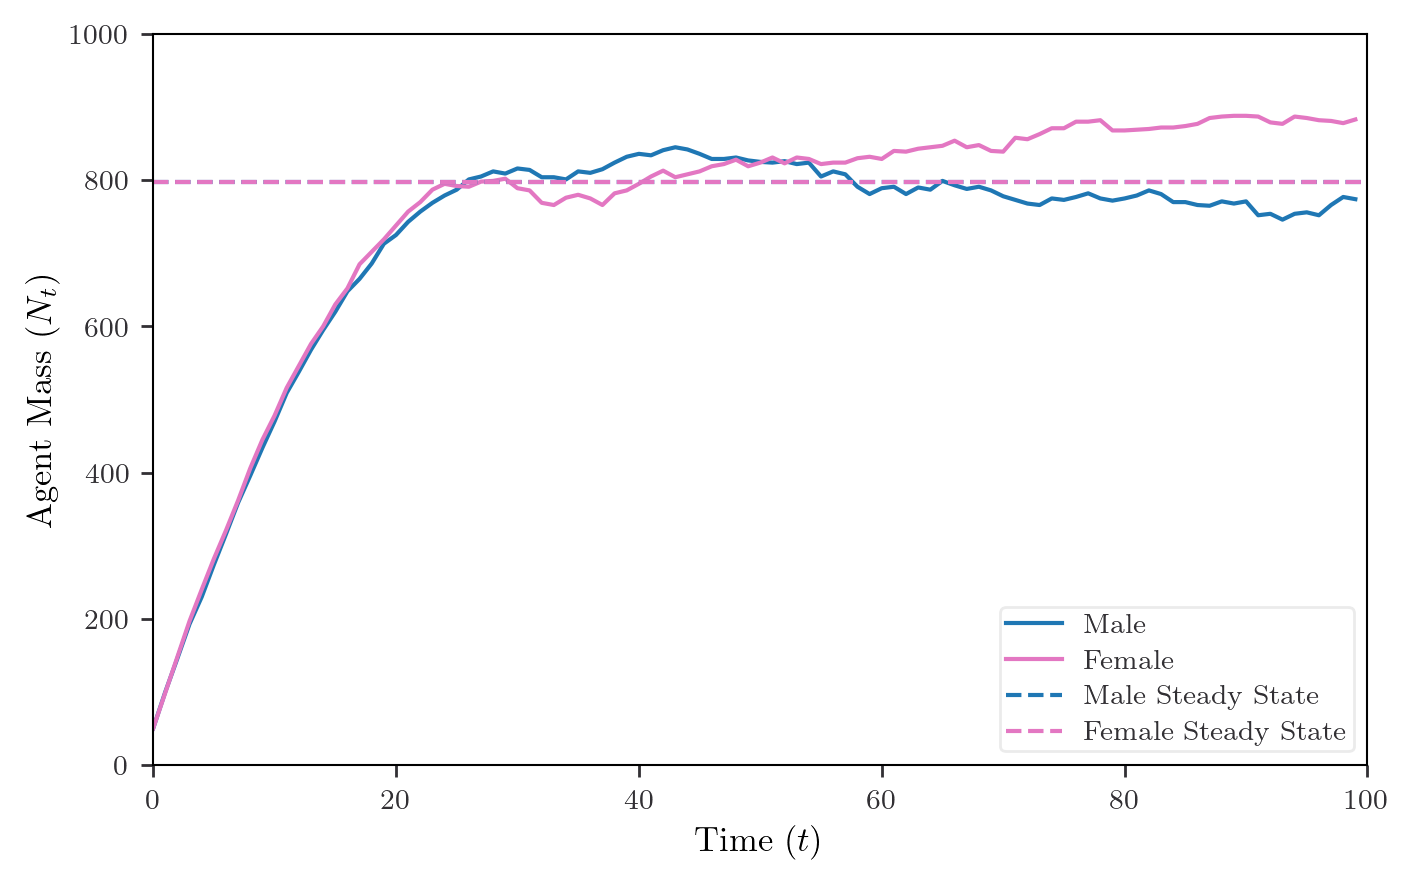

In [33]:
mass_by_sex = batch.groupby(['time', 'sex'], as_index=False).size() 
Nm_series = mass_by_sex[mass_by_sex.sex=='Male']['size']
Nw_series = mass_by_sex[mass_by_sex.sex=='Female']['size']

fig, ax = plt.subplots()
ax.set_xlim(0,T)  
ax.plot(range(0,T), Nm_series, color='tab:blue', label='Male') 
ax.plot(range(0,T), Nw_series, color='tab:pink', label='Female') 

ax.axhline(y=Nm, color='tab:blue', linestyle='--', label='Male Steady State')
ax.axhline(y=Nw, color='tab:pink', linestyle='--', label='Female Steady State')

ax.set(xlabel=r'Time ($t$)', ylabel=r'Agent Mass ($N_t$)')
ax.legend() 
plt.show() 

## Multiple Batch Agent-Based Simulation

In [34]:
simulations = []
batches = 10
for i in range(batches):
    game = simulate_game(T, μ_star, ω_star, exog_params(), i)
    simulations += game
    
data = pd.DataFrame(simulations) 

### Mass Convergence

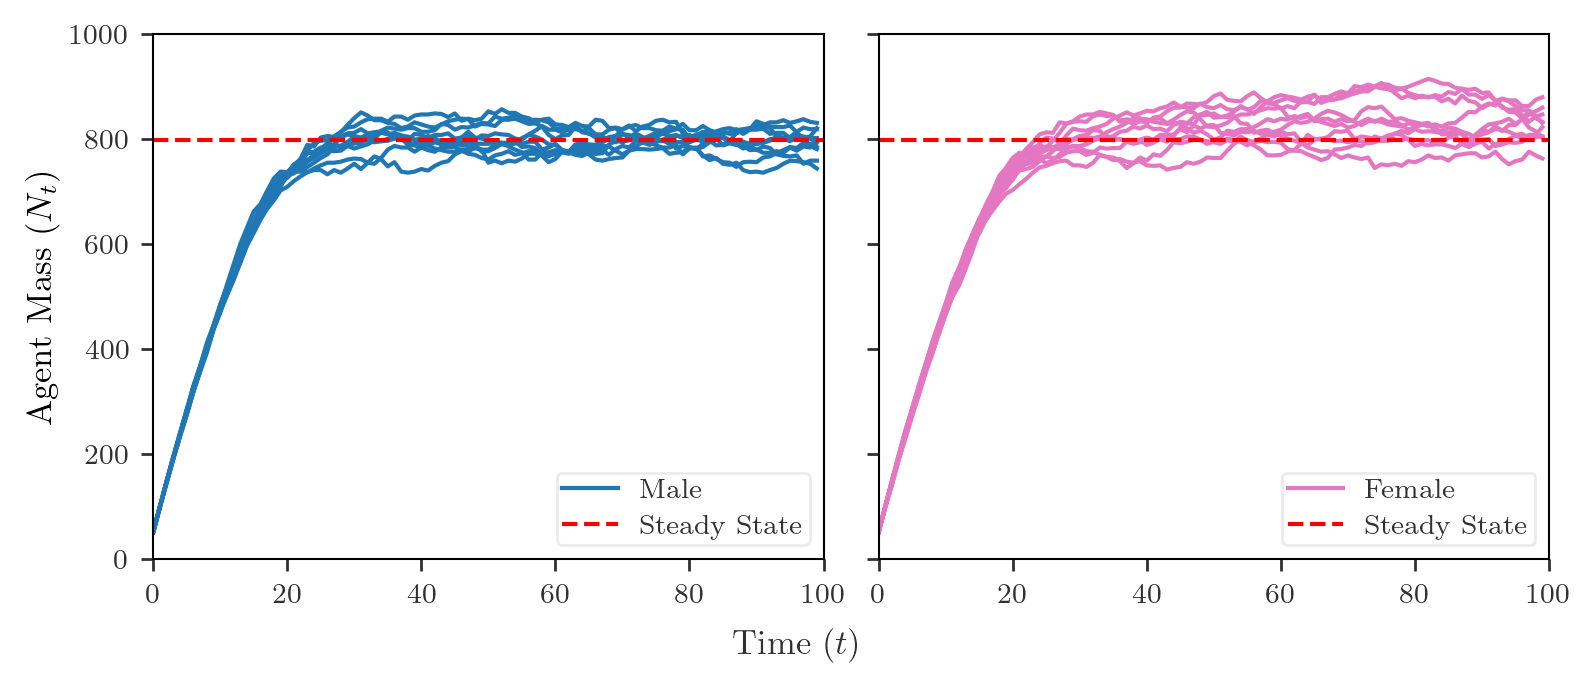

In [36]:
mass = data.groupby(['batch','time','sex'], as_index=False).size() 

fig, axs = plt.subplots(1,2, figsize=(6.267704441677044, 2.6368271881975483), constrained_layout=True, sharey=True)
axs[0].set_xlim(0,T)  
axs[1].set_xlim(0,T)   

for i in range(batches):
    if i==0:
        axs[0].plot(range(0,T), mass[(mass.batch==i)&(mass.sex=='Male')]['size'], color='tab:blue', label='Male')   
        axs[1].plot(range(0,T), mass[(mass.batch==i)&(mass.sex=='Female')]['size'], color='tab:pink', label='Female') 
    else:
        axs[0].plot(range(0,T), mass[(mass.batch==i)&(mass.sex=='Male')]['size'], color='tab:blue')   
        axs[1].plot(range(0,T), mass[(mass.batch==i)&(mass.sex=='Female')]['size'], color='tab:pink')

    
axs[0].set(ylabel=r'Agent Mass ($N_t$)')

axs[0].axhline(y=Nm, color='r', linestyle='--', label='Steady State')
axs[1].axhline(y=Nw, color='r', linestyle='--', label='Steady State')

axs[0].legend()
axs[1].legend()

fig.supxlabel('Time ($t$)', size=10) 
plt.savefig('../../figures/abm-conv.png', bbox_inches='tight')
plt.show()

## Varying Sample Sizes 

In [13]:
simulations = []
sstates = []
arrivals = [10, 100, 1000] 
for i, l in enumerate(arrivals):
    # Setting arrivals rate 
    print(f'Arrivals rate: {l}') 
    λm = l
    λw = l 

    # Solve for steady state 
    m_test = np.random.rand(Bm)
    w_test = np.random.rand(Bw)   
    x_start = np.concatenate((m_test, w_test), axis=None)
    solution = least_squares(SSE, x_start, bounds = (0,1), verbose=1)  
    μ_star = solution.x[:Bm]
    ω_star = solution.x[Bm:] 
    Nm, Nw, Pbm, Pbw, τm, τw, αm, αw = steady_state(μ_star, ω_star, True)
    print(f'Steady State Mass: {Nm + Nw}')
    sstates.append(Nm+Nw)

    # Simulating game
    game = simulate_game(T, μ_star, ω_star, exog_params(), i)
    simulations += game

data = pd.DataFrame(simulations) 

Arrivals rate: 10
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 7.5842e-01, final cost 1.2317e-15, first-order optimality 4.75e-09.
Steady State Mass: 319.0032712129166
Arrivals rate: 100
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 3.9886e-01, final cost 1.7409e-18, first-order optimality 1.84e-10.
Steady State Mass: 3190.0332910749703
Arrivals rate: 1000
`gtol` termination condition is satisfied.
Function evaluations 8, initial cost 9.3222e-01, final cost 9.8693e-18, first-order optimality 4.26e-10.
Steady State Mass: 31900.332602735703


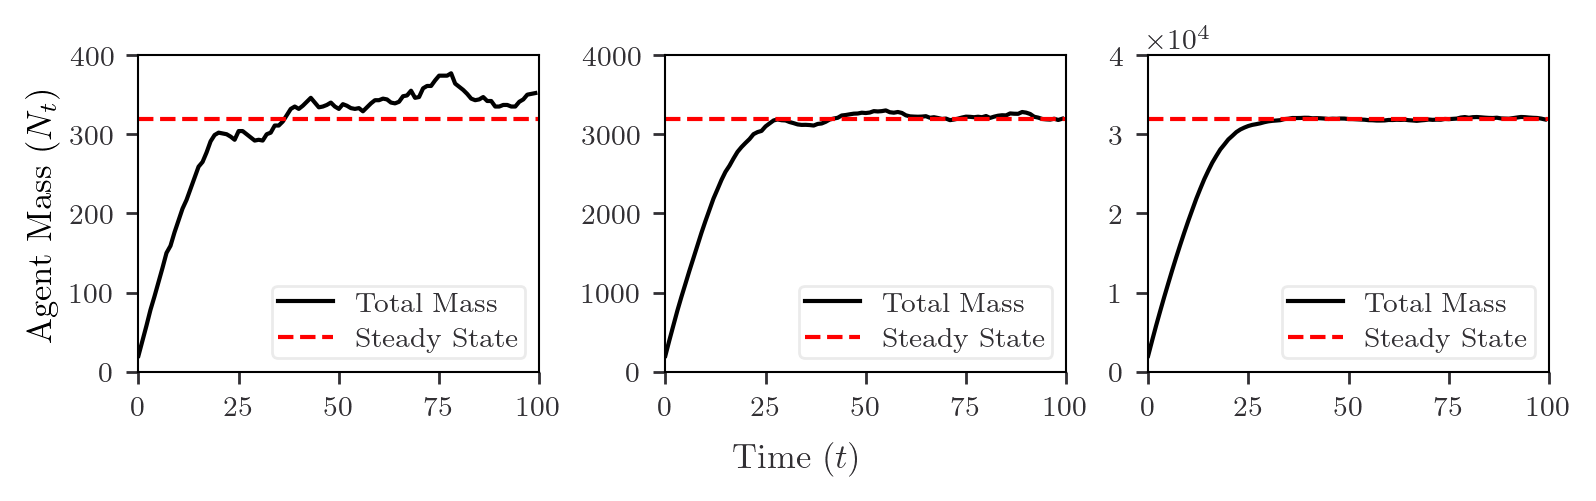

In [23]:
mass = data.groupby(['batch','time'], as_index=False).size()

fig, axs = plt.subplots(1,3, figsize=(6.267704441677044, 1.8912181254650321), constrained_layout=True) 

for i, l in enumerate(arrivals):
    axs[i].set_xlim(0,T)
    axs[i].plot(range(0,T), mass[(mass.batch==i)]['size'], color='k', label='Total Mass')
    axs[i].axhline(y=sstates[i], color='r', linestyle='--', label='Steady State')
    #axs[i].set(title=r'$\lambda=$' + str(l))
    axs[i].legend()

axs[0].set(ylabel=r'Agent Mass ($N_t$)')  
fig.supxlabel('Time ($t$)', size=10)

plt.savefig('../../figures/abm-conv-ssize.png', bbox_inches='tight')
plt.show()